In [728]:
'''Example script to generate text from Nietzsche's writings.
At least 20 epochs are required before the generated text
starts sounding coherent.
It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.
If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''
import sklearn
import itertools
import tensorflow as tf
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib
import time
import sys
import pymongo
sys.path.append('git/PRIM/source/')
sys.path.append('git/PRIM/scripts/')

import Plotting
import folium
import matplotlib
import osmMerger
import CustomUtils
import OsmProcessing
import pandas as pd
from functools import reduce


In [331]:
class PredictionModel:
    def __init__(self,data, input_lag, output_lag, sequence_length,scale_max=False,scale_log=False,shift_mean=False,y_only=False,add_time=False,max_value=130,valid_split=0.8,min_max_scale=False):
        self.data = data
        self.input_lag = input_lag
        self.output_lag = output_lag
        self.sequence_length = sequence_length
        self.scale_max = scale_max
        self.scale_log = scale_log
        self.shift_mean = shift_mean
        self.y_only=y_only
        self.add_time = add_time
        self.max_value = max_value
        self.min_max_scale = min_max_scale
        self.model=None
        self.valid_split=valid_split
        self.x,self.y,self.t =self.getXY()
        self.__reversed_process=[]
    
    
    
    def getDaysTypes(self):
        day_types = pd.DatetimeIndex(self.t.reshape(-1)).weekday.values.reshape(self.t.shape)
        time_fraction = (CustomUtils.timeToSeconds(pd.DatetimeIndex(data_model.t.reshape(-1)))/(60*60)).values.reshape(self.t.shape)
        time_input = np.concatenate([day_types,time_fraction],1)
        return time_input[:int(len(self.x)*(self.valid_split))],time_input[int(len(self.x)*(self.valid_split)):]
    
    def getExamples(self,sequence,hours):
        sequence_length=len(sequence)
        sub_sequence_length = self.input_lag+self.output_lag
        if sub_sequence_length > sequence_length :
            raise ValueError("sequence length {} too small for lags : {},{}".format(sequence_length,input_lag,output_lag))
        return [sequence[i:i+input_lag] for i in range(0,sequence_length-sub_sequence_length+1,1)],\
               [sequence[i+input_lag:i+input_lag+output_lag] for i in range(0,sequence_length-sub_sequence_length+1,1)],\
               [hours[i+input_lag:i+input_lag+output_lag] for i in range(0,sequence_length-sub_sequence_length+1,1)]  
    
    def getXY(self):
        nsegs,ntime=self.data.shape
        if(ntime%self.sequence_length)!= 0 :
            raise ValueError("sequence length {} not compatible with number of time features {}".format(self.sequence_length,ntime))

        shapedData = self.data.values.T.reshape(int(ntime/self.sequence_length),self.sequence_length,nsegs)
        timestamps = pd.Series(self.data.columns).values.reshape(int(ntime/self.sequence_length),self.sequence_length)
        
        examples=[self.getExamples(x,hours) for x,hours in zip(shapedData,timestamps)]

        x,y,t = list(zip(*examples))
        return np.concatenate(x), np.concatenate(y), np.concatenate(t)
    
    
    def getIndexes(self,idx):
        cx,cy= (idx +(self.input_lag+self.output_lag-1)*(idx//(self.sequence_length - self.input_lag-self.output_lag+1)),\
                idx +(self.input_lag+self.output_lag-1)*(idx//(self.sequence_length - self.input_lag-self.output_lag+1))+self.input_lag )
        return (self.data.columns[cx:cy].values,self.data.columns[cy:cy+self.output_lag].values)
    
    def scaleMax(self):
        self.__reversed_process.append(self.reverseScaleMax)
        self.x/=self.max_value
        if not self.y_only:
            self.y/=self.max_value
        
    def scaleMinMax(self):
        self.__reversed_process.append(self.reverseMinMaxScale)
        self.min =self.x[:int(len(self.x)*(self.valid_split))].min()
        self.max =self.x[:int(len(self.x)*(self.valid_split))].max()
        diff = self.max - self.min
        self.x = (self.x-self.min)/diff
        self.y = (self.y-self.min)/diff

        
    def reverseMinMaxScale(self,x):
        return x*(self.max-self.min)+self.min
    
    def reverseScaleMax(self,y):
        return y*self.max_value

        
    def scaleLog(self):
        self.__reversed_process.append(self.reverseScaleLog)
        
        self.x=np.log1p(self.x)
        self.y=np.log1p(self.y)
        
    def reverseScaleLog(self,y):
        return np.expm1(y)       
        
    def addTime(self):
        self.__reversed_process.append(self.removeTime)
        self.x=np.concatenate((self.x,self.t.reshape(-1,self.t.shape[1],1)),2)
        
        
    def removeTime(self,y):
        if y.shape == self.x.shape :
            return np.delete(data_model.x,data_model.x.shape[2]-1,axis=2)
        return y
        
    def shiftMean(self):
        self.__reversed_process.append(self.resetMean)
        self.means  =  self.data[self.data.columns[:(int(len(self.data.columns)*self.valid_split))]].mean(axis=1).values
        if not self.y_only :
            self.x-=self.means
        self.y-=self.means
        
    def resetMean(self,y):
        return y+self.means
        
        
    def preprocessData(self):
        if self.shift_mean :
            self.shiftMean()
        if self.scale_max :
            self.scaleMax()
        if self.scale_log :
            self.scaleLog()
        if self.min_max_scale : 
            self.scaleMinMax()
        if self.add_time :
            self.addTime()

        if self.output_lag == 1 :
            self.y=self.y.reshape(-1,self.y.shape[2])

    def getRawYData(self,y):
        
        return reduce(lambda res, f:f(res), self.__reversed_process[::-1], y)

    
    def mse(self,p,y=None):
        pred = self.getRawYData(p)
        if y is not None :
            raw_y = self.getRawYData(y)
        else :
            raw_y = self.getRawYData(self.y)
        return np.mean((pred-raw_y)**2)
    
    def mae(self,p,y=None):
        pred = self.getRawYData(p)
        if y is not None :
            raw_y = self.getRawYData(y)
        else :
            raw_y = self.getRawYData(self.y)
        return np.mean(abs(pred-raw_y))
    
    def trainSplit(self):
        
        x_train = self.x[:int(len(self.x)*(self.valid_split))]
        x_test = self.x[int(len(self.x)*(self.valid_split)):]
        y_train = self.y[:int(len(self.x)*(self.valid_split))]
        y_test = self.y[int(len(self.x)*(self.valid_split)):]
        return x_train,y_train,x_test,y_test
    
    def getSplitSequences(self,values,sequence_length,skip=0):
        def addNans(values,sequence_length,skip):

            values=values.reshape(-1,sequence_length)
            nans=np.array([np.nan]*(values.shape[0]*(skip+1))).reshape(values.shape[0],-1)
            values = np.concatenate((values,nans),axis=1).reshape(-1)
            return values
        return addNans(np.arange(len(values)),sequence_length,skip), addNans(values,sequence_length,skip)
    
    def restorePredictionsAsDF(self,preds):
        
        index = [self.getIndexes(i)[1][0] for i in range(len(preds))]
        df = pd.DataFrame(self.getRawYData(preds),index=index,columns=self.data.index)
        return df.T
    
    def restoreXAsDF(self,x):
        index = [self.getIndexes(i)[1][0] for i in range(len(x))]
        df = pd.DataFrame(self.getRawYData(x).swapaxes(1,2).tolist(),index=index,columns=self.data.index)
        return df.T
    
    def predict(self,split="full"):
        secondary_input = self.getDaysTypes()
        if split.lower() == "full":
            main_input = self.x
            secondary_input = np.concatenate(secondary_input)
        if split.lower() == "train":
            main_input,*_ = self.trainSplit()
            secondary_input=secondary_input[0]
        if split.lower() == "test":
            *_,main_input,_ = self.trainSplit()
            secondary_input=secondary_input[1]
            
        if(len(self.model.input_shape)==1):
            return self.model.predict(main_input)
        
        return self.model.predict([main_input,secondary_input])

In [332]:
def fillNaWithHistoricalValues(df):
    oldIdx = df.columns
    idx=[pd.to_datetime(df.columns.values).date,pd.to_datetime(df.columns.values).time]
    mIdx=pd.MultiIndex.from_arrays(idx,names=['day','time'])
    df.set_axis(mIdx,axis=1,inplace=True)
    df = df.add(df.isna()*df.groupby(by=df.columns.get_level_values(1),axis=1).mean(),fill_value=0)
    df.set_axis(oldIdx,axis=1,inplace=True)
    return df
def dropWeekends(data):
    data.drop(data.columns[[ x.date().weekday()>=5 for x  in data.columns]],axis=1,inplace=True)
#     data.drop(data.columns[[ x.date()==data.columns[0].date() for x  in data.columns]],axis=1,inplace=True)


In [333]:
speeds = pd.read_pickle('/home/dsi/mbouchouia/code/speeds1419.pckl')
counts = pd.read_pickle('/home/dsi/mbouchouia/code/counts1419.pckl')

In [334]:
dropWeekends(speeds)
dropWeekends(counts)

In [335]:
# mergeResults,segmentsMeta= osmMerger.mergeSegments(minValidData = osmMerger.MIN_VALID_DATA, weights=osmMerger.WEIGHTS,speedsMx=speeds)
# mergeResults.to_pickle("mergeResults.pckl")
# segmentsMeta.to_pickle("segmentsMeta.pckl")

In [336]:
mergeResults=pd.read_pickle("mergeResults.pckl")
segmentsMeta=pd.read_pickle("segmentsMeta.pckl")

In [729]:
from mongoConnection import *

In [741]:
segments=OsmProcessing.getSegments(osmWays)
segments = OsmProcessing.setOneWay(segments)
osmMerger.mergeRoundaboutChunks(segments)
segmentsMeta = OsmProcessing.buildSegmentsMeta(segments,linearOnly=True)
osmMerger.removeRounabouts(segmentsMeta)

In [743]:
meta

,segmentID,changeset,key,loc,nodes,relations,tag,timestamp,version,oneWay,maxSpeed,ins,outs,length
segmentIndex,,,,,,,,,,,,,,
0,35478524_0,0,"[highway, name, ref]","{'type': 'LineString', 'coordinates': [[-1.552...","[267155684, 267155685, 3175585464, 267155686, ...",NaN,"{'highway': 'tertiary', 'name': 'Route de Cess...",2019-01-14T22:12:58Z,10,0,NaN,"[1, 3, 17]","[5232, 5234]",3.339625
1,376692521_0,0,"[highway, name, ref]","{'type': 'LineString', 'coordinates': [[-1.531...","[268370430, 268370431, 271190690, 271190693, 3...",NaN,"{'highway': 'tertiary', 'name': 'Route des Gré...",2018-11-06T07:45:34Z,2,0,NaN,[],"[0, 5231]",1.121172
2,226057036_0,0,"[highway, ref]","{'type': 'LineString', 'coordinates': [[-1.564...","[2949766072, 3578288374, 3044204622, 317558697...",NaN,"{'highway': 'tertiary', 'ref': 'D 286'}",2018-08-17T01:09:52Z,9,0,NaN,"[4, 5236]",[],2.194664
3,302201368_0,0,"[highway, name, oneway, surface]","{'type': 'LineString', 'coordinates': [[-1.536...","[1935448364, 3800885017, 3800885016, 193544838...",NaN,"{'highway': 'tertiary', 'name': 'Route de la G...",2017-07-03T20:58:32Z,4,0,NaN,[],"[0, 5231]",1.510357
4,317106155_0,0,"[highway, name, ref, source]","{'type': 'LineString', 'coordinates': [[-1.579...","[267155637, 267155639, 4056506831, 3175587677,...",NaN,"{'highway': 'tertiary', 'name': 'Route de Doml...",2017-11-28T20:29:22Z,3,0,NaN,[113],"[2, 5]",1.510986
5,543380718_0,0,"[highway, name, ref, source]","{'type': 'LineString', 'coordinates': [[-1.564...","[2949766072, 2949766073, 2297576732]",NaN,"{'highway': 'tertiary', 'name': 'Route de Doml...",2017-11-28T20:29:11Z,1,0,NaN,"[4, 5233]",[5237],0.088547
6,220667241_0,0,"[bridge, highway, layer, note, ref]","{'type': 'LineString', 'coordinates': [[-1.565...","[2297576730, 2297576732]",NaN,"{'bridge': 'yes', 'highway': 'tertiary', 'laye...",2017-11-28T20:29:21Z,5,0,NaN,[7],[5236],0.034567
7,220667242_0,0,"[highway, name, ref]","{'type': 'LineString', 'coordinates': [[-1.565...","[2297563152, 2297576730]",NaN,"{'highway': 'tertiary', 'name': 'Route de Doml...",2017-11-28T20:29:21Z,4,0,NaN,[11],[6],0.029881
8,220665949_0,0,"[ref, name, source, highway]","{'type': 'LineString', 'coordinates': [[-1.565...","[2297563160, 2297563163, 2297563166, 229756316...",NaN,"{'ref': 'D 32', 'name': 'Route de Domloup', 's...",2014-11-08T20:52:56Z,4,0,NaN,[9],[17],0.468339


In [742]:
segmentsMeta

,segmentID,changeset,key,loc,nodes,relations,tag,timestamp,version,oneWay,maxSpeed,ins,outs,length
segmentIndex,,,,,,,,,,,,,,
0,35478524_0,0,"[highway, name, ref]","{'type': 'LineString', 'coordinates': [[-1.552...","[267155684, 267155685, 3175585464, 267155686, ...",NaN,"{'highway': 'tertiary', 'name': 'Route de Cess...",2019-01-14T22:12:58Z,10,0,NaN,[17],[],3.339625
1,376692521_0,0,"[highway, name, ref]","{'type': 'LineString', 'coordinates': [[-1.531...","[268370430, 268370431, 271190690, 271190693, 3...",NaN,"{'highway': 'tertiary', 'name': 'Route des Gré...",2018-11-06T07:45:34Z,2,0,NaN,[],[],1.121172
2,226057036_0,0,"[highway, ref]","{'type': 'LineString', 'coordinates': [[-1.564...","[2949766072, 3578288374, 3044204622, 317558697...",NaN,"{'highway': 'tertiary', 'ref': 'D 286'}",2018-08-17T01:09:52Z,9,0,NaN,"[4, 4935]",[],2.194664
3,302201368_0,0,"[highway, name, oneway, surface]","{'type': 'LineString', 'coordinates': [[-1.536...","[1935448364, 3800885017, 3800885016, 193544838...",NaN,"{'highway': 'tertiary', 'name': 'Route de la G...",2017-07-03T20:58:32Z,4,0,NaN,[],[],1.510357
4,317106155_0,0,"[highway, name, ref, source]","{'type': 'LineString', 'coordinates': [[-1.579...","[267155637, 267155639, 4056506831, 3175587677,...",NaN,"{'highway': 'tertiary', 'name': 'Route de Doml...",2017-11-28T20:29:22Z,3,0,NaN,[110],"[2, 5]",1.510986
5,543380718_0,0,"[highway, name, ref, source]","{'type': 'LineString', 'coordinates': [[-1.564...","[2949766072, 2949766073, 2297576732]",NaN,"{'highway': 'tertiary', 'name': 'Route de Doml...",2017-11-28T20:29:11Z,1,0,NaN,"[4, 4932]",[4936],0.088547
6,220667241_0,0,"[bridge, highway, layer, note, ref]","{'type': 'LineString', 'coordinates': [[-1.565...","[2297576730, 2297576732]",NaN,"{'bridge': 'yes', 'highway': 'tertiary', 'laye...",2017-11-28T20:29:21Z,5,0,NaN,[7],[4935],0.034567
7,220667242_0,0,"[highway, name, ref]","{'type': 'LineString', 'coordinates': [[-1.565...","[2297563152, 2297576730]",NaN,"{'highway': 'tertiary', 'name': 'Route de Doml...",2017-11-28T20:29:21Z,4,0,NaN,[11],[6],0.029881
8,220665949_0,0,"[ref, name, source, highway]","{'type': 'LineString', 'coordinates': [[-1.565...","[2297563160, 2297563163, 2297563166, 229756316...",NaN,"{'ref': 'D 32', 'name': 'Route de Domloup', 's...",2014-11-08T20:52:56Z,4,0,NaN,[9],[17],0.468339


In [719]:
segmentsMeta.loc[segmentsMeta.segmentID.isin(updatedSpeed.index.values)]

,segmentID,changeset,key,loc,nodes,relations,tag,timestamp,version,oneWay,maxSpeed,ins,outs,length
segmentIndex,,,,,,,,,,,,,,
82,4926492_0,0,"[highway, highway_link, legal, link, name, one...","{'type': 'LineString', 'coordinates': [[-1.607...","[30432709, 4613245719, 303705110, 4613245568, ...",NaN,"{'highway': 'trunk_link', 'highway_link': 'pri...",2018-09-17T17:05:02Z,13,1,NaN,[],[],0.688607
83,466546390_0,0,"[highway, int_ref, lanes, legal, looks_like, m...","{'type': 'LineString', 'coordinates': [[-1.609...","[267892466, 25959629, 25959399, 4613245016]",[2306546],"{'highway': 'trunk', 'int_ref': 'E 50', 'lanes...",2018-09-18T13:58:47Z,5,1,90.0,[2515],[88],0.370438
84,466546391_0,0,"[highway, int_ref, lanes, legal, looks_like, m...","{'type': 'LineString', 'coordinates': [[-1.606...","[26593552, 4613245017, 26593554, 266182260]",[2306546],"{'highway': 'trunk', 'int_ref': 'E 50', 'lanes...",2018-09-18T13:58:47Z,5,1,90.0,[89],[2514],0.369585
87,5037447_0,0,"[destination, highway, highway_link, legal, li...","{'type': 'LineString', 'coordinates': [[-1.600...","[26593551, 4613245035, 4613245031, 4613245030,...",NaN,"{'destination': 'Rennes Centre;Cesson Sud', 'h...",2018-09-17T17:05:02Z,16,1,70.0,[107],[],0.692635
88,222139156_0,0,"[highway, int_ref, lanes, legal, looks_like, m...","{'type': 'LineString', 'coordinates': [[-1.605...","[4613245016, 4613245026, 4613245024, 461324502...",[2306546],"{'highway': 'trunk', 'int_ref': 'E 50', 'lanes...",2018-09-18T13:58:41Z,10,1,90.0,[83],[109],1.047615
89,222139157_0,0,"[destination, highway, int_ref, lanes, legal, ...","{'type': 'LineString', 'coordinates': [[-1.600...","[26593551, 4613245034, 4613245032, 3762870492,...",[2306546],"{'destination': 'Angers;Nantes', 'highway': 't...",2018-09-18T13:58:41Z,9,1,90.0,[107],"[84, 85]",0.460399
107,564021863_0,0,"[highway, int_ref, lanes, legal, looks_like, m...","{'type': 'LineString', 'coordinates': [[-1.594...","[26593549, 4615018210, 26593550, 4615018304, 4...",[2306546],"{'highway': 'trunk', 'int_ref': 'E 50', 'lanes...",2018-09-18T13:58:49Z,5,1,90.0,[108],"[87, 89]",0.543083
108,289704911_0,0,"[highway, int_ref, lanes, legal, looks_like, m...","{'type': 'LineString', 'coordinates': [[-1.591...","[2307871866, 4615018213, 26593549]",[2306546],"{'highway': 'trunk', 'int_ref': 'E 50', 'lanes...",2018-09-18T13:58:42Z,8,1,90.0,[210],[107],0.275590
109,466760891_0,0,"[highway, int_ref, lanes, legal, looks_like, m...","{'type': 'LineString', 'coordinates': [[-1.594...","[4615018209, 4615018212, 2307871870]",[2306546],"{'highway': 'trunk', 'int_ref': 'E 50', 'lanes...",2018-09-18T13:58:48Z,5,1,90.0,[88],[211],0.229197


In [725]:
segmentsMeta.loc[segmentsMeta.segmentID.isin(updatedSpeed.index.values)].apply(lambda x : (len(x['ins']),len(x['outs'])),axis = 1).value_counts()

(1, 1)    365
(0, 1)     65
(1, 2)     61
(2, 1)     59
(1, 0)     58
(0, 2)     35
(2, 2)     30
(2, 0)     26
(0, 0)     13
(3, 2)      7
(3, 1)      7
(1, 3)      6
(3, 3)      4
(3, 0)      3
(2, 3)      2
(0, 3)      2
(2, 4)      1
(1, 4)      1
(4, 1)      1
(4, 2)      1
(5, 1)      1
dtype: int64

In [337]:
mergedIndex=pd.Series(data=segmentsMeta.loc[mergeResults]['segmentID'].values,index = segmentsMeta['segmentID'].values)

In [338]:
updatedSpeed = speeds.assign(newIndex =mergedIndex.reindex(speeds.index).values)
updatedSpeed = updatedSpeed[~updatedSpeed.newIndex.isna()]
updatedSpeed.groupby('newIndex').mean().to_pickle("rawUpdatedSpeed1419.pckl")
updatedSpeed=updatedSpeed.groupby('newIndex').mean().dropna(thresh = int(0.8*len(updatedSpeed.columns)))
updatedSpeed.to_pickle("updatedSpeed1419.pckl")
updatedSpeed=fillNaWithHistoricalValues(updatedSpeed)
updatedSpeed.to_pickle("updatedSpeedWithHistoricalValues1419.pckl")

In [339]:
rawSpeed= fillNaWithHistoricalValues(speeds.groupby('matching_road').mean().dropna(thresh = int(0.8*len(speeds.columns))))

In [340]:
fullSegs=speeds.groupby('matching_road').mean().dropna()

In [341]:
updatedcounts = counts.assign(newIndex =mergedIndex.reindex(counts.index).values)
updatedcounts = updatedcounts[~updatedcounts.newIndex.isna()]
updatedcounts = updatedcounts.groupby('newIndex').sum().loc[updatedSpeed.index]

In [342]:
def createMlpModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):

    model = tf.keras.models.Sequential()
    #layers
    model.add(tf.keras.layers.Flatten())
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.Dense(neuronsPerLayer*(i+1)))
    model.add(tf.keras.layers.Dense(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [343]:
def createStackedLstmModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):
    model = tf.keras.models.Sequential()
    #layers
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.LSTM(neuronsPerLayer*(i+1),return_sequences=True))
    model.add(tf.keras.layers.LSTM(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [344]:
build_grid= {'optimizer':['Adam'],
              'nlayers':[0,1,3],
              'neuronsPerLayer':[64],
              'loss':['MSE','MAE'],
              'relu_output':[False]
             }

train_grid={
    "batch_size":[8,32,64], 
    "epochs":[100], 
    "validation_split":[0.5]
}

preprocess_grid={
    'scale_Max':[True],
    'scale_log':[False],
    'input_lag':[1,6],
    'output_lag':[1],
    'time_as_input':[True],
    "validation_split":[0.5]

}

In [345]:
def getParamsFromGrid(grid):
    return [dict(list(zip(list(grid.keys()),x ))) for x in list(itertools.product(*list(grid.values())))]

In [346]:
def grid_search(data,buildfunc,build_grid,train_grid,preprocess_grid):

    grid = list(itertools.product( getParamsFromGrid(build_grid),
                                   getParamsFromGrid(train_grid),
                                   getParamsFromGrid(preprocess_grid)
                                 )
               )
    
    losses=[]
    val_losses=[]
    mseLoss=[]
    mseValLoss=[]
    for build_param,train_param,preprocess_param in grid :
        print(build_param,train_param,preprocess_param)
        x,y = preprocessData(data,**preprocess_param)
        xtrain = x[:int(len(x)*(train_param['validation_split']))]
        xtest = x[int(len(x)*(train_param['validation_split'])):]
        ytrain = y.reshape(-1,nSegments)[:int(len(x)*(train_param['validation_split']))]
        ytest = y.reshape(-1,nSegments)[int(len(x)*(train_param['validation_split'])):]
        tf.keras.backend.clear_session()
        tf.keras.backend.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)))

        model=buildfunc(**build_param)
        model.fit(xtrain,ytrain.reshape(-1,nSegments),validation_data = (xtest,ytest), **train_param,verbose=0)
        
        losses.append(model.evaluate(xtrain,ytrain,verbose=0))
        val_losses.append(model.evaluate(xtest,ytest,verbose=0))
        
        mseLoss.append(mse(reversePreProcess(ytrain,**preprocess_param),reversePreProcess(model.predict(xtrain),**preprocess_param)))
        mseValLoss.append(mse(reversePreProcess(ytest,**preprocess_param),reversePreProcess(model.predict(xtest),**preprocess_param)))
        print(losses[-1],val_losses[-1],mseLoss[-1],mseValLoss[-1])
        
    resDF=pd.DataFrame(list(zip(grid,losses,val_losses,mseLoss,mseValLoss)),columns=['params','loss_value','val_loss_value','mseLoss','mseValLoss'])
    
    return  pd.concat([resDF.params.apply(lambda x : pd.Series({**x[0],**x[1],**x[2]})),resDF[['loss_value','val_loss_value','mseLoss','mseValLoss']]],axis=1)


In [347]:
# resMlpDF = grid_search(data,createMlpModel,build_grid,train_grid,preprocess_grid)

In [348]:
# resLstmDF.groupby("time_as_input")['mseLoss'].describe()

In [349]:
# resLstmDF = grid_search(data,createStackedLstmModel,build_grid,train_grid,preprocess_grid)

In [350]:
def multiInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(100,name="full_speed_mpl")(flatten_layer)
    mlp = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="slice_MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [351]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(50,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    

In [698]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""
def multiInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( x)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)   
    data_model.model.summary()

In [707]:
nSegments = len(updatedSpeed)
input_lag, output_lag, sequence_length = 2, 1, 20
valid_split = 0.6
data_model = PredictionModel(updatedSpeed, input_lag, output_lag, sequence_length, valid_split=valid_split,shift_mean=True,min_max_scale=True)
data_model.preprocessData()
x_train, y_train, x_test, y_test = data_model.trainSplit()
train_days, test_days= data_model.getDaysTypes()
tf.keras.backend.clear_session()
multiInputModelLstm()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 2, 748)       0                                            
__________________________________________________________________________________________________
speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
__________________________________________________________________________________________________
day_time_input (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                 day_time_input[0][0]             
__________

In [710]:
data_model.model.summary()
modelHist = data_model.model.fit([x_train,train_days], y_train, validation_data = ([x_test,test_days], y_test), batch_size=28, epochs=75, verbose=1,shuffle=False)
print(data_model.mse(data_model.predict('train'),y_train),data_model.mse(data_model.predict('test'),y_test))
print(data_model.mae(data_model.predict('train'),y_train),data_model.mae(data_model.predict('test'),y_test))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 2, 748)       0                                            
__________________________________________________________________________________________________
speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
__________________________________________________________________________________________________
day_time_input (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                 day_time_input[0][0]             
__________

In [686]:
set([x.date() for x in speeds.columns])

{datetime.date(2018, 11, 13),
 datetime.date(2018, 11, 14),
 datetime.date(2018, 11, 16),
 datetime.date(2018, 11, 19),
 datetime.date(2018, 11, 20),
 datetime.date(2018, 11, 21),
 datetime.date(2018, 11, 22),
 datetime.date(2018, 11, 27),
 datetime.date(2018, 11, 28),
 datetime.date(2018, 11, 29),
 datetime.date(2018, 11, 30),
 datetime.date(2018, 12, 10),
 datetime.date(2018, 12, 11)}

In [416]:
# mns = data_model.means

In [450]:
# data preprocessing
nSegments = len(updatedSpeed)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.7
data_model = PredictionModel(updatedSpeed, input_lag, output_lag, sequence_length, valid_split=valid_split,min_max_scale=True)
data_model.preprocessData()
x_train, y_train, x_test, y_test = data_model.trainSplit()
train_days, test_days= data_model.getDaysTypes()

# xcounts,_=preprocessData(updatedcounts/updatedcounts.max(),input_lag=input_lag, output_lag=output_lag)
# if add_counts :
#     x=np.concatenate((x,xcounts),axis = 2)

# tensorborad callbacks
tfBoard=tf.keras.callbacks.TensorBoard(log_dir='./tflogs/'+time.ctime(), histogram_freq=10,write_grads=True,  
          write_graph=True, write_images=True)

# simple MLP model
tf.keras.backend.clear_session()

main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
reshape_layer = tf.keras.layers.Reshape(x_train.shape[1:][::-1])(main_input)

x = tf.keras.layers.LSTM(350)(main_input)

const_dense = tf.keras.layers.Dense(nSegments,trainable=False,kernel_initializer="zeros",bias_initializer=lambda shape,dtype,partition_info : mns/mns.max())(daytime_input)

merge_layer = tf.keras.layers.Concatenate(1, name="Merge")([x, daytime_input,const_dense])

x=tf.keras.layers.Dense(350, activation = tf.keras.activations.relu )( merge_layer )

output_layer = tf.keras.layers.Dense(nSegments, name="Output")(x)

data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer])

optimizer = tf.keras.optimizers.Adam()

data_model.model.compile( loss=tf.keras.losses.mse, optimizer=optimizer ) #,metrics=['mse','msle','mae','mape'])


In [451]:
data_model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 5, 748)       0                                            
__________________________________________________________________________________________________
day_time_input (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 350)          1538600     speed_input[0][0]                
__________________________________________________________________________________________________
dense (Dense)                   (None, 748)          2244        day_time_input[0][0]             
__________________________________________________________________________________________________
Merge (Con

In [452]:
modelHist = data_model.model.fit([x_train,train_days], y_train, validation_data = ([x_test,test_days], y_test), batch_size=8, epochs=100, verbose=1,shuffle=False)
data_model.mse(data_model.predict('train'),y_train),data_model.mse(data_model.predict('test'),y_test)

Train on 136 samples, validate on 59 samples
Epoch 1/100
136/136 [==============================] - 1s 8ms/sample - loss: 0.1168 - val_loss: 0.0205
Epoch 2/100
136/136 [==============================] - 0s 3ms/sample - loss: 0.0189 - val_loss: 0.0140
Epoch 3/100
136/136 [==============================] - 0s 3ms/sample - loss: 0.0136 - val_loss: 0.0118
Epoch 4/100
136/136 [==============================] - 0s 3ms/sample - loss: 0.0122 - val_loss: 0.0111
Epoch 5/100
136/136 [==============================] - 0s 3ms/sample - loss: 0.0115 - val_loss: 0.0107
Epoch 6/100
136/136 [==============================] - 0s 3ms/sample - loss: 0.0112 - val_loss: 0.0105
Epoch 7/100
136/136 [==============================] - 0s 3ms/sample - loss: 0.0110 - val_loss: 0.0106
Epoch 8/100
136/136 [==============================] - 0s 3ms/sample - loss: 0.0109 - val_loss: 0.0107
Epoch 9/100
136/136 [==============================] - 0s 3ms/sample - loss: 0.0110 - val_loss: 0.0109
Epoch 10/100
136/136 [======

In [456]:
data_model.mse(data_model.predict('train'),y_train),data_model.mse(data_model.predict('test'),y_test)

(129.3542781109411, 145.67363939863043)

In [424]:
# weights shapes
[x.shape for x in data_model.model.get_weights()]

[(748, 400),
 (100, 400),
 (400,),
 (2, 100),
 (2, 748),
 (748,),
 (948, 100),
 (100,),
 (100, 748),
 (748,)]

In [444]:
data_model.mse(data_model.predict('train'),y_train),data_model.mse(data_model.predict('test'),y_test)

(198.92626245873777, 191.400492506835)

In [426]:
def createSubPlots(data,pltFunc=plt.plot,figsize=(12,12),titles=None):
    nCols= int(np.sqrt(len(data)))+1
    plt.figure(figsize=figsize)
    for i,vals in enumerate(data):
        plt.subplot(nCols,nCols,i+1)
        plt.plot(vals)
        if type(titles)!=type(None):
            plt.title(titles[i])
    plt.tight_layout()

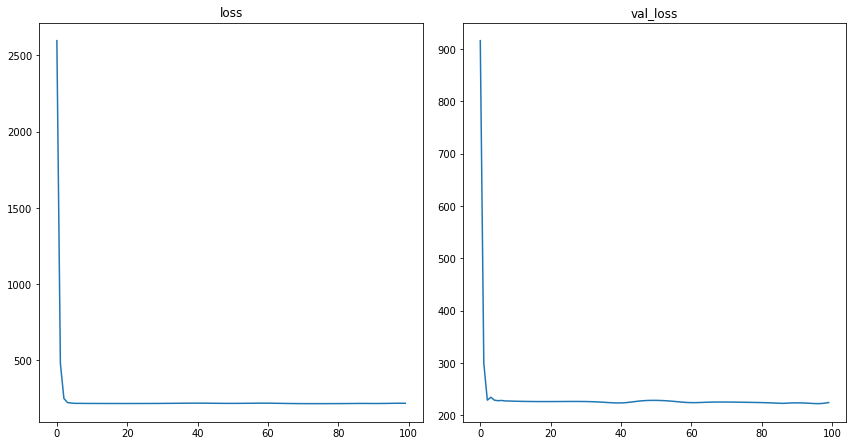

In [427]:
createSubPlots(modelHist.history.values(),titles=list(modelHist.history.keys()))

In [428]:
def forceDiscontinuity(values,sequenceLength,skip=0):
    def addNans(values,sequenceLength,skip):
        
        values=values.reshape(-1,sequenceLength)
        nans=np.array([np.nan]*(values.shape[0]*(skip+1))).reshape(values.shape[0],-1)
        values = np.concatenate((values,nans),axis=1).reshape(-1)
        return values
    return addNans(np.arange(len(values)),sequenceLength,skip), addNans(values,sequenceLength,skip)

In [429]:
cd /home/dsi/mbouchouia/code

/home/dsi/mbouchouia/code


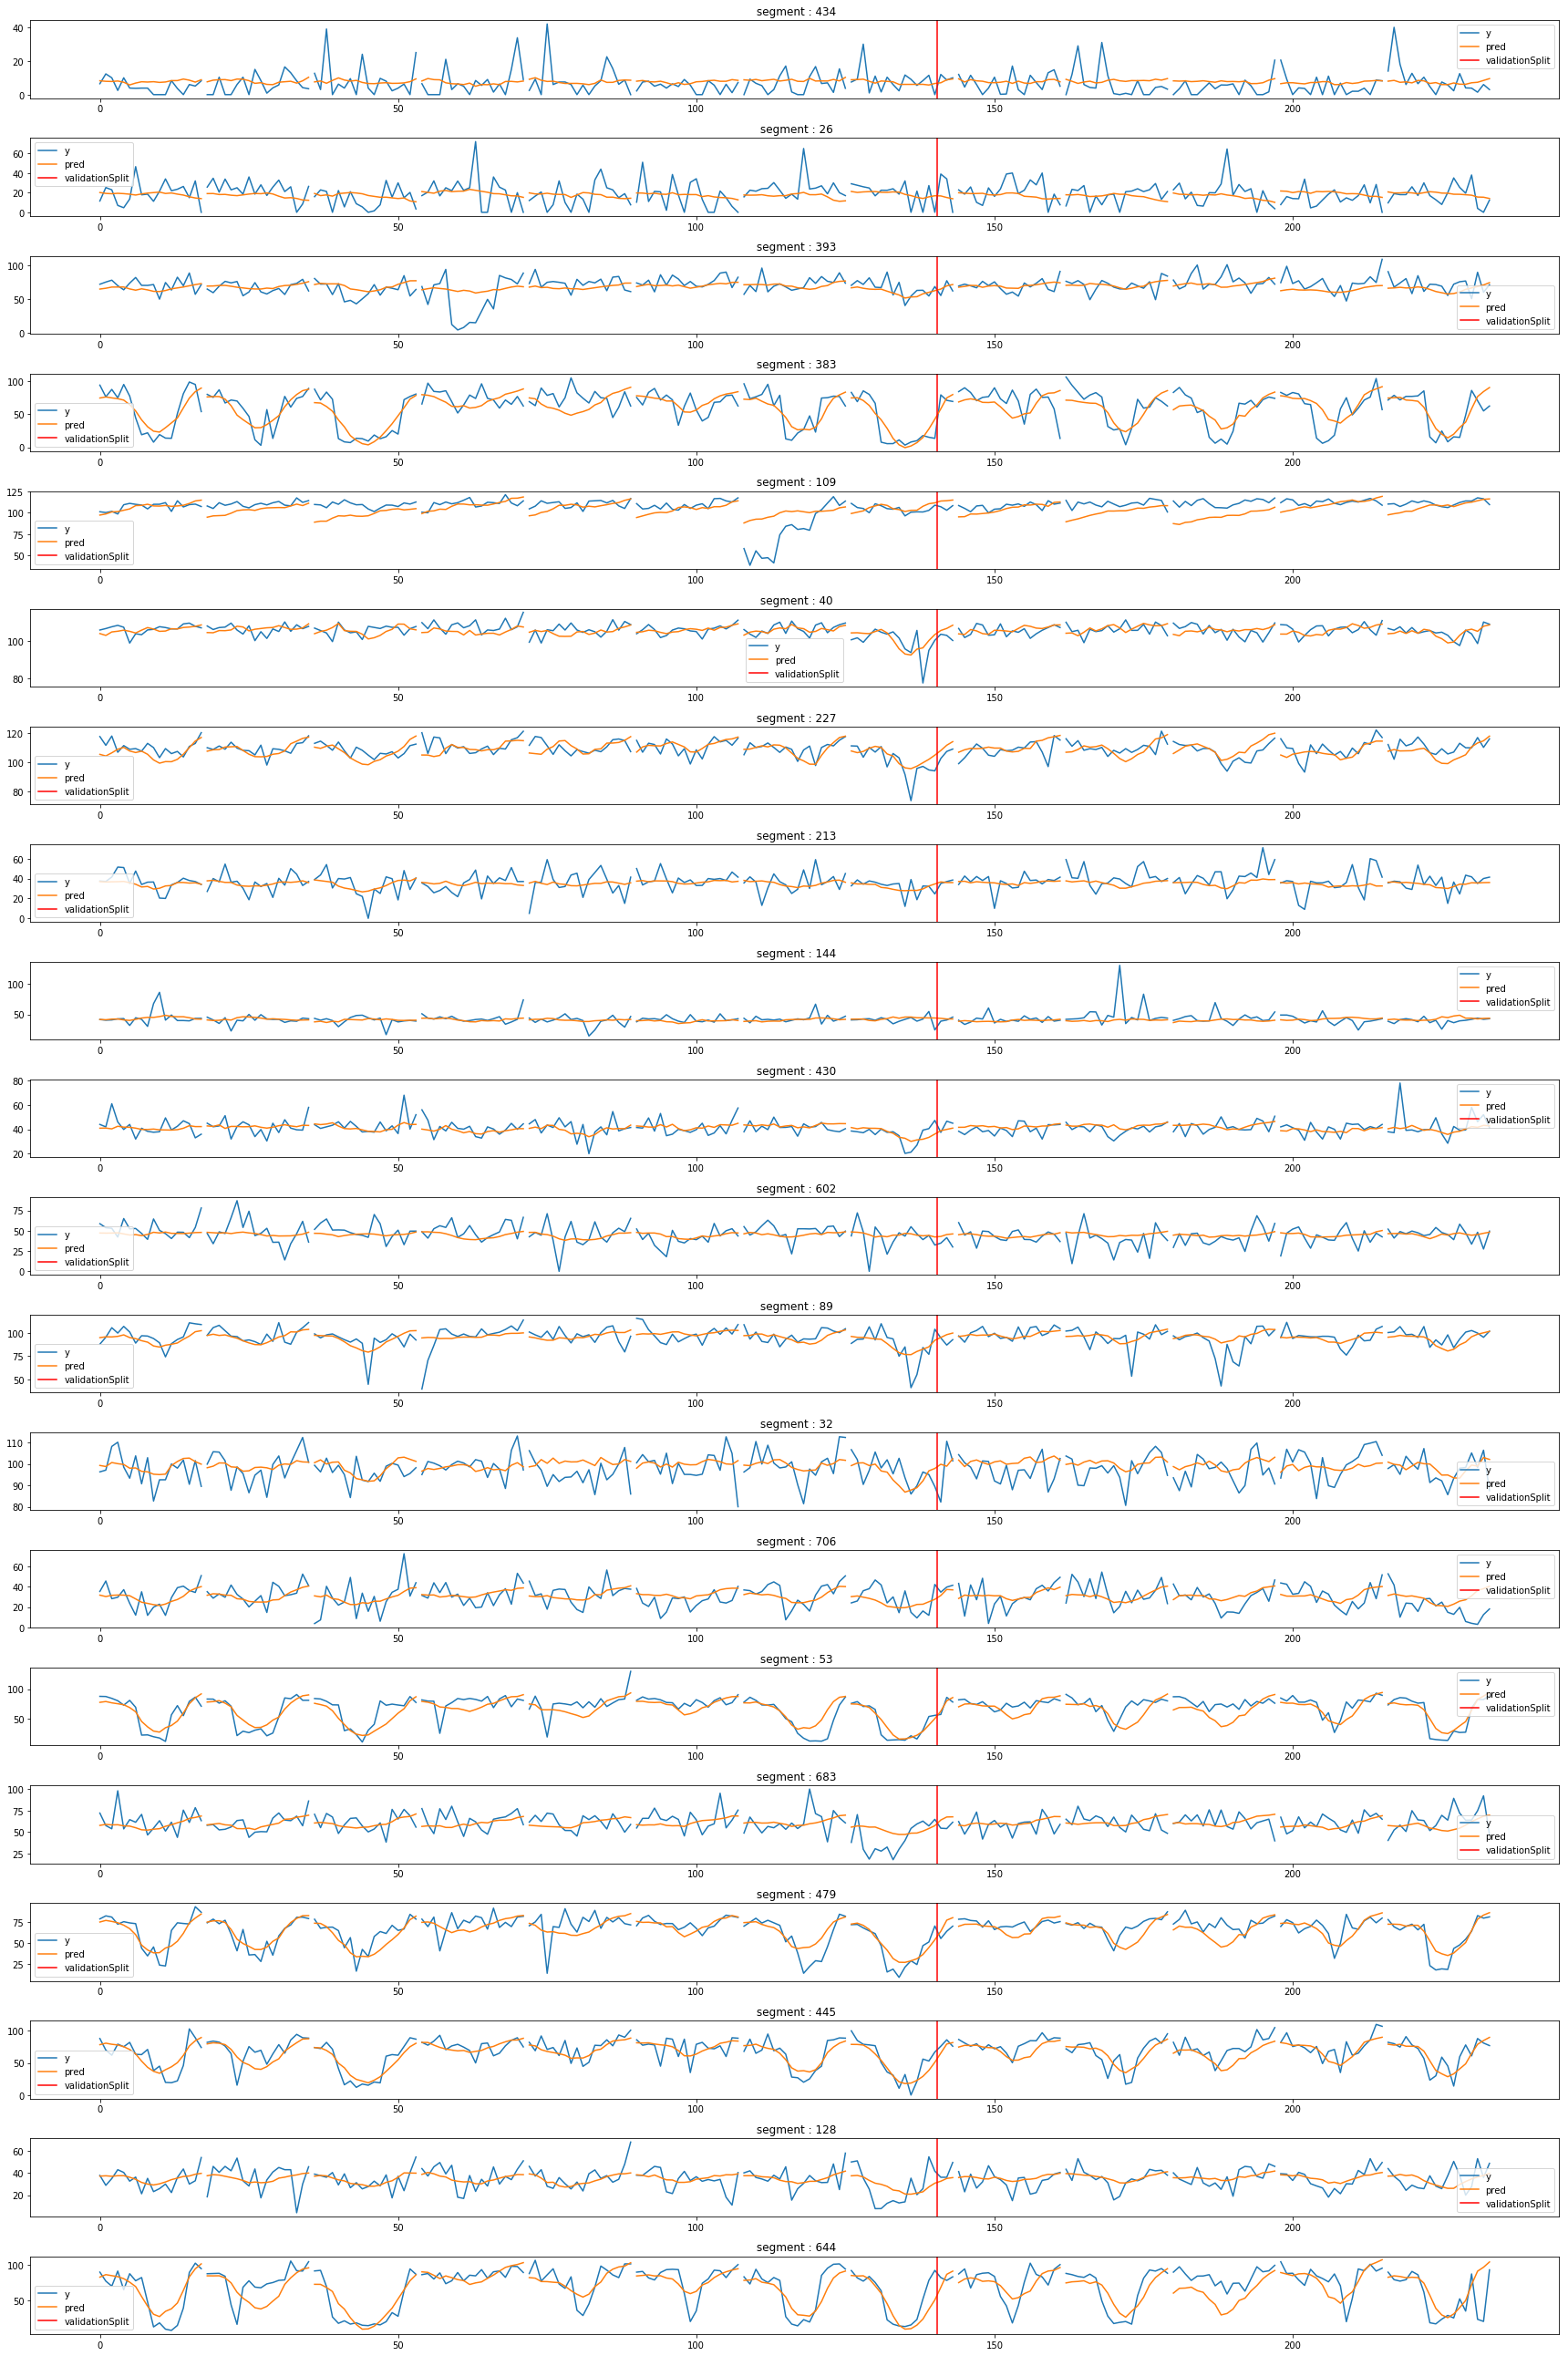

In [655]:
samplePred = np.argsort(data_model.y.mean(axis=0)[0]-data_model.predict('full').mean(axis=0))[np.r_[:nSegments-1:20j].astype(int)]

plt.figure(figsize=(24,36))
preds = data_model.getRawYData(data_model.predict('full'))
yys = data_model.getRawYData(data_model.y)
for ix, xSample in enumerate(samplePred):
    plt.subplot(len(samplePred),1,ix+1)
    plt.plot(*data_model.getSplitSequences(yys[:,ix],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
    plt.plot(*data_model.getSplitSequences(preds[:,ix],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))

    plt.axvline((data_model.valid_split)*data_model.x.shape[0],c='r')
    plt.legend(['y','pred','validationSplit'])
    plt.title(" segment : {}".format(xSample))
plt.tight_layout()
# preds = pd.concat([getPred(x,y,i,idx=30,mul=MUL) for i in range(len(x))],axis=1).T
# plt.figure(figsize=(18,4))
# plt.plot(preds['y'].values)
# plt.plot(preds['pred'].values)
# plt.axvline(0.75*x.shape[0],c='r')
# plt.legend(['y','pred','validationSplit'])
# plt.savefig("imgs/Dense instant overfit with counts and time.png",dpi=1200,bbox_inches='tight')

In [1573]:
# samplePred = np.argsort(data_model.y.mean(axis=0)[0]-model.predict(data_model.x).mean(axis=0))[np.r_[:nSegments-1:10j].astype(int)]

# plt.figure(figsize=(24,18))
# preds = data_model.getRawYData(model.predict(data_model.x))
# yys = data_model.getRawYData(data_model.y)
# for ix, xSample in enumerate(samplePred):
#     plt.subplot(len(samplePred),1,ix+1)
#     plt.plot(*data_model.getSplitSequences(yys[:,ix],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
#     plt.plot(*data_model.getSplitSequences(preds[:,ix],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))

#     plt.axvline((data_model.valid_split)*data_model.x.shape[0],c='r')
#     plt.legend(['y','pred','validationSplit'])
#     plt.title(" segment : {}".format(xSample))
    
# plt.tight_layout()
# # preds = pd.concat([getPred(x,y,i,idx=30,mul=MUL) for i in range(len(x))],axis=1).T
# # plt.figure(figsize=(18,4))
# # plt.plot(preds['y'].values)
# # plt.plot(preds['pred'].values)
# # plt.axvline(0.75*x.shape[0],c='r')
# # plt.legend(['y','pred','validationSplit'])
# # plt.savefig("imgs/Dense instant overfit with counts and time.png",dpi=1200,bbox_inches='tight')

In [561]:
def plotPredictions(segments,data_model, yDF,predDF, timesteps,mergedIndex,updatedcounts,folium_map=None):
    if folium_map == None :
        folium_map = Plotting.getFoliumMap()
    layers=[]
    colors = ((np.abs(yDF.clip(lower=15) - predDF.clip(lower=15))+1)/(yDF.clip(lower=15)+1)).clip(upper=1)
    laggedX = data_model.restoreXAsDF(data_model.x)
    predSegs = segments[segments.segmentID.isin(mergedIndex[mergedIndex.isin(yDF.index)].index)]
    segment_overall_mean = [data_model.data.mean(axis=1).loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
    segment_timestamp_mean = data_model.data.groupby(pd.DatetimeIndex(data_model.data.columns).time,axis=1).mean()
    for t in timesteps :  
        colorList=[colors[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        y= [yDF[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        preds = [predDF[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        segCounts=[updatedcounts[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        timestampLaggedX= [laggedX[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        
        current_segment_timestamp_mean = [segment_timestamp_mean[t.time()].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        
        popups = ["segment : {:},<br> y : {:.2f},<br> pred : {:.2f},<br> %error : {:.0f}%,<br> count : {:}<br>mean: {:}<br>timestamp_mean: {:}<br>x: {:} "\
                  .format(seg,yi,predi,props*100,count,mean,timestamp_mean,np.array(x).astype(int)) 
                  for seg,yi,predi,props,count,mean,timestamp_mean,x 
                  in zip(predSegs.segmentID,y,preds,colorList,segCounts,segment_overall_mean,current_segment_timestamp_mean,timestampLaggedX)]
        pos = yDF.columns.get_loc(t)
        layer = getPredictionLayer(predSegs,colorList,folium_map,str(t),popups)
        layers.append(layer)
        
    return Plotting.stackHistotyLayers([*layers,folium.TileLayer()],folium_map)

def getPredictionLayer(segments,colors,folium_map,name='layer',popups=[]):
    layer = folium.plugins.FeatureGroupSubGroup(folium_map,name=name,show=False, overlay=False)
    [folium.PolyLine(locations=[lo[::-1] for lo in x['coordinates']], color=matplotlib.colors.rgb2hex(plt.cm.brg_r(color/2)),popup=pop).add_to(layer) for x,color,pop in zip(segments['loc'],colors,popups)]
    return layer

yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))


# folium_map = plotPredictions(segmentsMeta,data_model, yDF, predDF, yDF.columns[np.r_[:len(yDF.columns)-1:10j].astype(int)],mergedIndex,updatedcounts)


folium_map=folium.plugins.DualMap(location=[48.10301,-1.65537],
                    zoom_start=13,
                    tiles="OpenStreetMap")
folium.features.LinearColormap([plt.cm.brg_r(0),plt.cm.brg_r(0.5)],caption="Error rate").add_to(folium_map.m1)

folium_train_map = plotPredictions(segmentsMeta,data_model,yDF,predDF,yDF.columns[np.r_[8:14:1].astype(int)],mergedIndex,updatedcounts,folium_map=folium_map.m1)
folium_validation_map = plotPredictions(segmentsMeta,data_model,yDF,predDF,yDF.columns[np.r_[len(yDF.columns)*valid_split+8:len(yDF.columns)*valid_split+14:1].astype(int)],mergedIndex,updatedcounts,folium_map=folium_map.m2)



In [563]:
225/6

37.5

In [562]:
folium_map.save('predsLstmTimeMerge0.6 6lokkup.html')

In [1429]:
colors = ((np.abs(yDF - predDF)+1)/(yDF+1)).clip(upper=1)

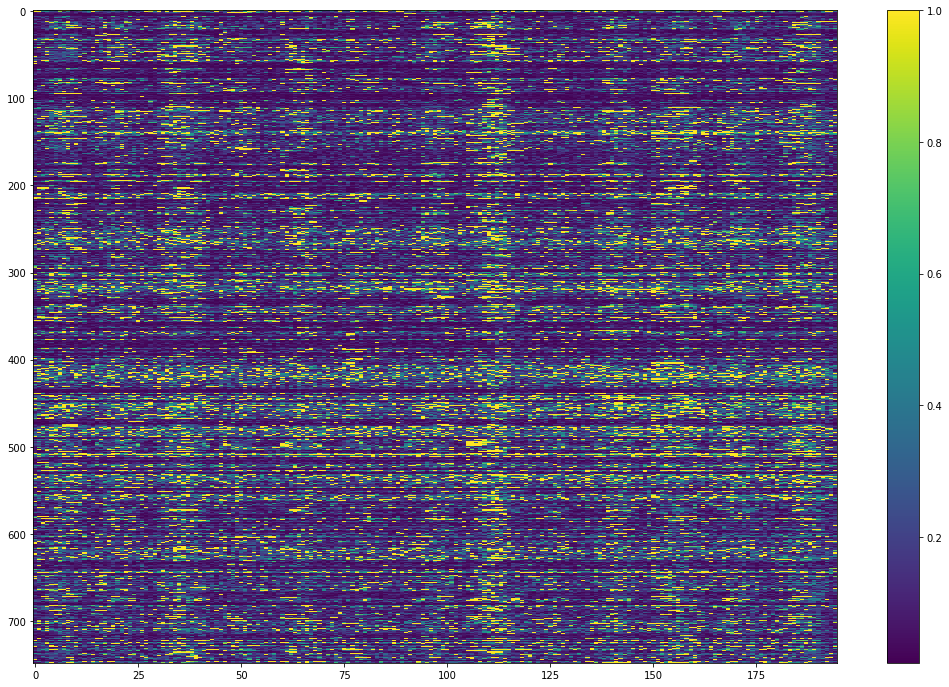

In [1430]:
def plotPredHeatMap(yDF,predDF,cost=None):
    if cost :
        colors= cost(yDF,predDF)
    else :
        colors = ((np.abs(yDF - predDF)+1)/(yDF+1)).clip(upper=1)
    
    plt.figure(figsize=(18,12))
    plt.imshow(colors,aspect='auto')
    plt.colorbar()
    
plotPredHeatMap(yDF,predDF)

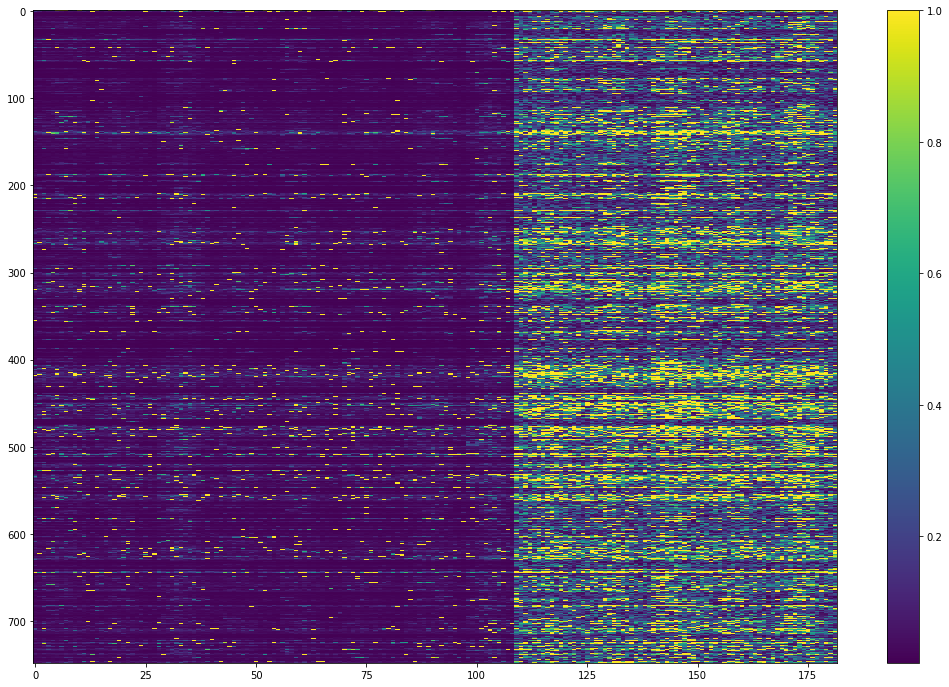

In [2036]:
def plotPredHeatMap(yDF,predDF,cost=None):
    if cost :
        colors= cost(yDF,predDF)
    else :
        colors = ((np.abs(yDF - predDF)+1)/(yDF+1)).clip(upper=1)
    
    plt.figure(figsize=(18,12))
    plt.imshow(colors,aspect='auto')
    plt.colorbar()
    
plotPredHeatMap(yDF,predDF)
plt.savefig("imgs/Dense instant overfit with counts and time heatmap.png",dpi=1200,bbox_inches='tight')